In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Problem Focus: "Begin by defining economic regimes based on inflation or growth trends. Try to find the optimal hedge for the S&P 500 depending on which economic regime you are in. The hedges will be a mix of gold and US treasuries."

1. **Data Preparation**: The `prepare_data` function is used to prepare the data for analysis. It converts the date columns to datetime and sets them as the index. It also calculates the returns for the S&P 500, Gold, and Bonds.

2. **Defining Economic Regimes**: The `define_regimes` function is used to define economic regimes based on GDP and CPI data. It creates four different regimes: High Growth Low Inflation (HGLI), High Growth High Inflation (HGHI), Low Growth Low Inflation (LGLI), and Low Growth High Inflation (LGHI).

3. **Applying Regimes to Market Data**: The `apply_regimes` function is used to apply the defined regimes to the market data. It creates a DataFrame with all dates and merges it with the regimes. It then forward fills the regimes and merges them with the market data.

4. **Portfolio Optimization**: The `optimize_portfolio` function is used to find the optimal weights for Gold and Bonds that maximize the Sharpe Ratio for each economic regime. It uses the `scipy.optimize.minimize` function to perform the optimization.

5. **Analyzing Regimes and Optimizing Hedges**: The `analyze_regimes` function is used to analyze the regimes and optimize the hedges. It loops through each regime, extracts the relevant data, and calls the `optimize_portfolio` function to get the optimal weights. It also calculates the correlations of the S&P 500 returns with the Gold and Bond returns.

6. **Main Execution and Results Display**: The `main` function is the main execution function that calls all the other functions. It prepares the data, defines the regimes, applies the regimes to the market data, and analyzes the regimes to get the optimal weights. It then prints out the optimal hedge weights, the correlations with the S&P 500, and the regime distribution.


# 1. Loading excel files

In [2]:
excel_file = "/Users/linhtrankhanh/Downloads/Data_180724.xlsx"

In [3]:
macro_df = pd.read_excel(excel_file, sheet_name = "Macro")
prices_df = pd.read_excel(excel_file, sheet_name = "Prices")
yield_df = pd.read_excel(excel_file, sheet_name = "Yield")

# 2. Data Preparation 

In [4]:
def prepare_data(macro_df, prices_df, yield_df):
    macro_df['Date'] = pd.to_datetime(macro_df['Date'])
    macro_df.set_index('Date', inplace=True)
    prices_df.set_index('Date', inplace=True)
    yield_df.set_index('Date', inplace=True)
    # Ensure macro_df is at month-end
    macro_df = macro_df.resample('M').last()

    # Merge prices and yields
    market_data = prices_df.merge(yield_df, left_index=True, right_index=True, how='outer')
    
    macro_df['GDP YOY'] = macro_df['GDP YOY'].ffill()
    market_data['S&P 500'] = market_data['S&P 500'].ffill()
    market_data['Gold'] = market_data['Gold'].ffill()
    # Calculate returns
    market_data['S&P_500_Return'] = market_data['S&P 500'].pct_change()
    market_data['Gold_Return'] = market_data['Gold'].pct_change()
    market_data['Bond_Return'] = -market_data['US 10YR Bonds'].diff()

    return macro_df, market_data
macro_df, market_data = prepare_data(macro_df, prices_df, yield_df)

In [5]:
macro_df.head()

,GDP YOY,CPI YOY
Date,,
1970-12-31,-0.2,5.6
1971-01-31,-0.2,5.3
1971-02-28,-0.2,5.0
1971-03-31,2.7,4.7
1971-04-30,2.7,4.2


In [6]:
market_data.head()

,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds,S&P_500_Return,Gold_Return,Bond_Return
Date,,,,,,,
1970-12-31,92.15,37.44,120.643,6.502,NaN,NaN,NaN
1971-01-04,91.15,37.44,120.530,6.462,-0.010852,0.0,0.04
1971-01-05,91.80,37.44,120.520,6.472,0.007131,0.0,-0.01
1971-01-06,92.35,37.44,120.490,6.472,0.005991,0.0,-0.00
1971-01-07,92.38,37.44,120.550,6.452,0.000325,0.0,0.02


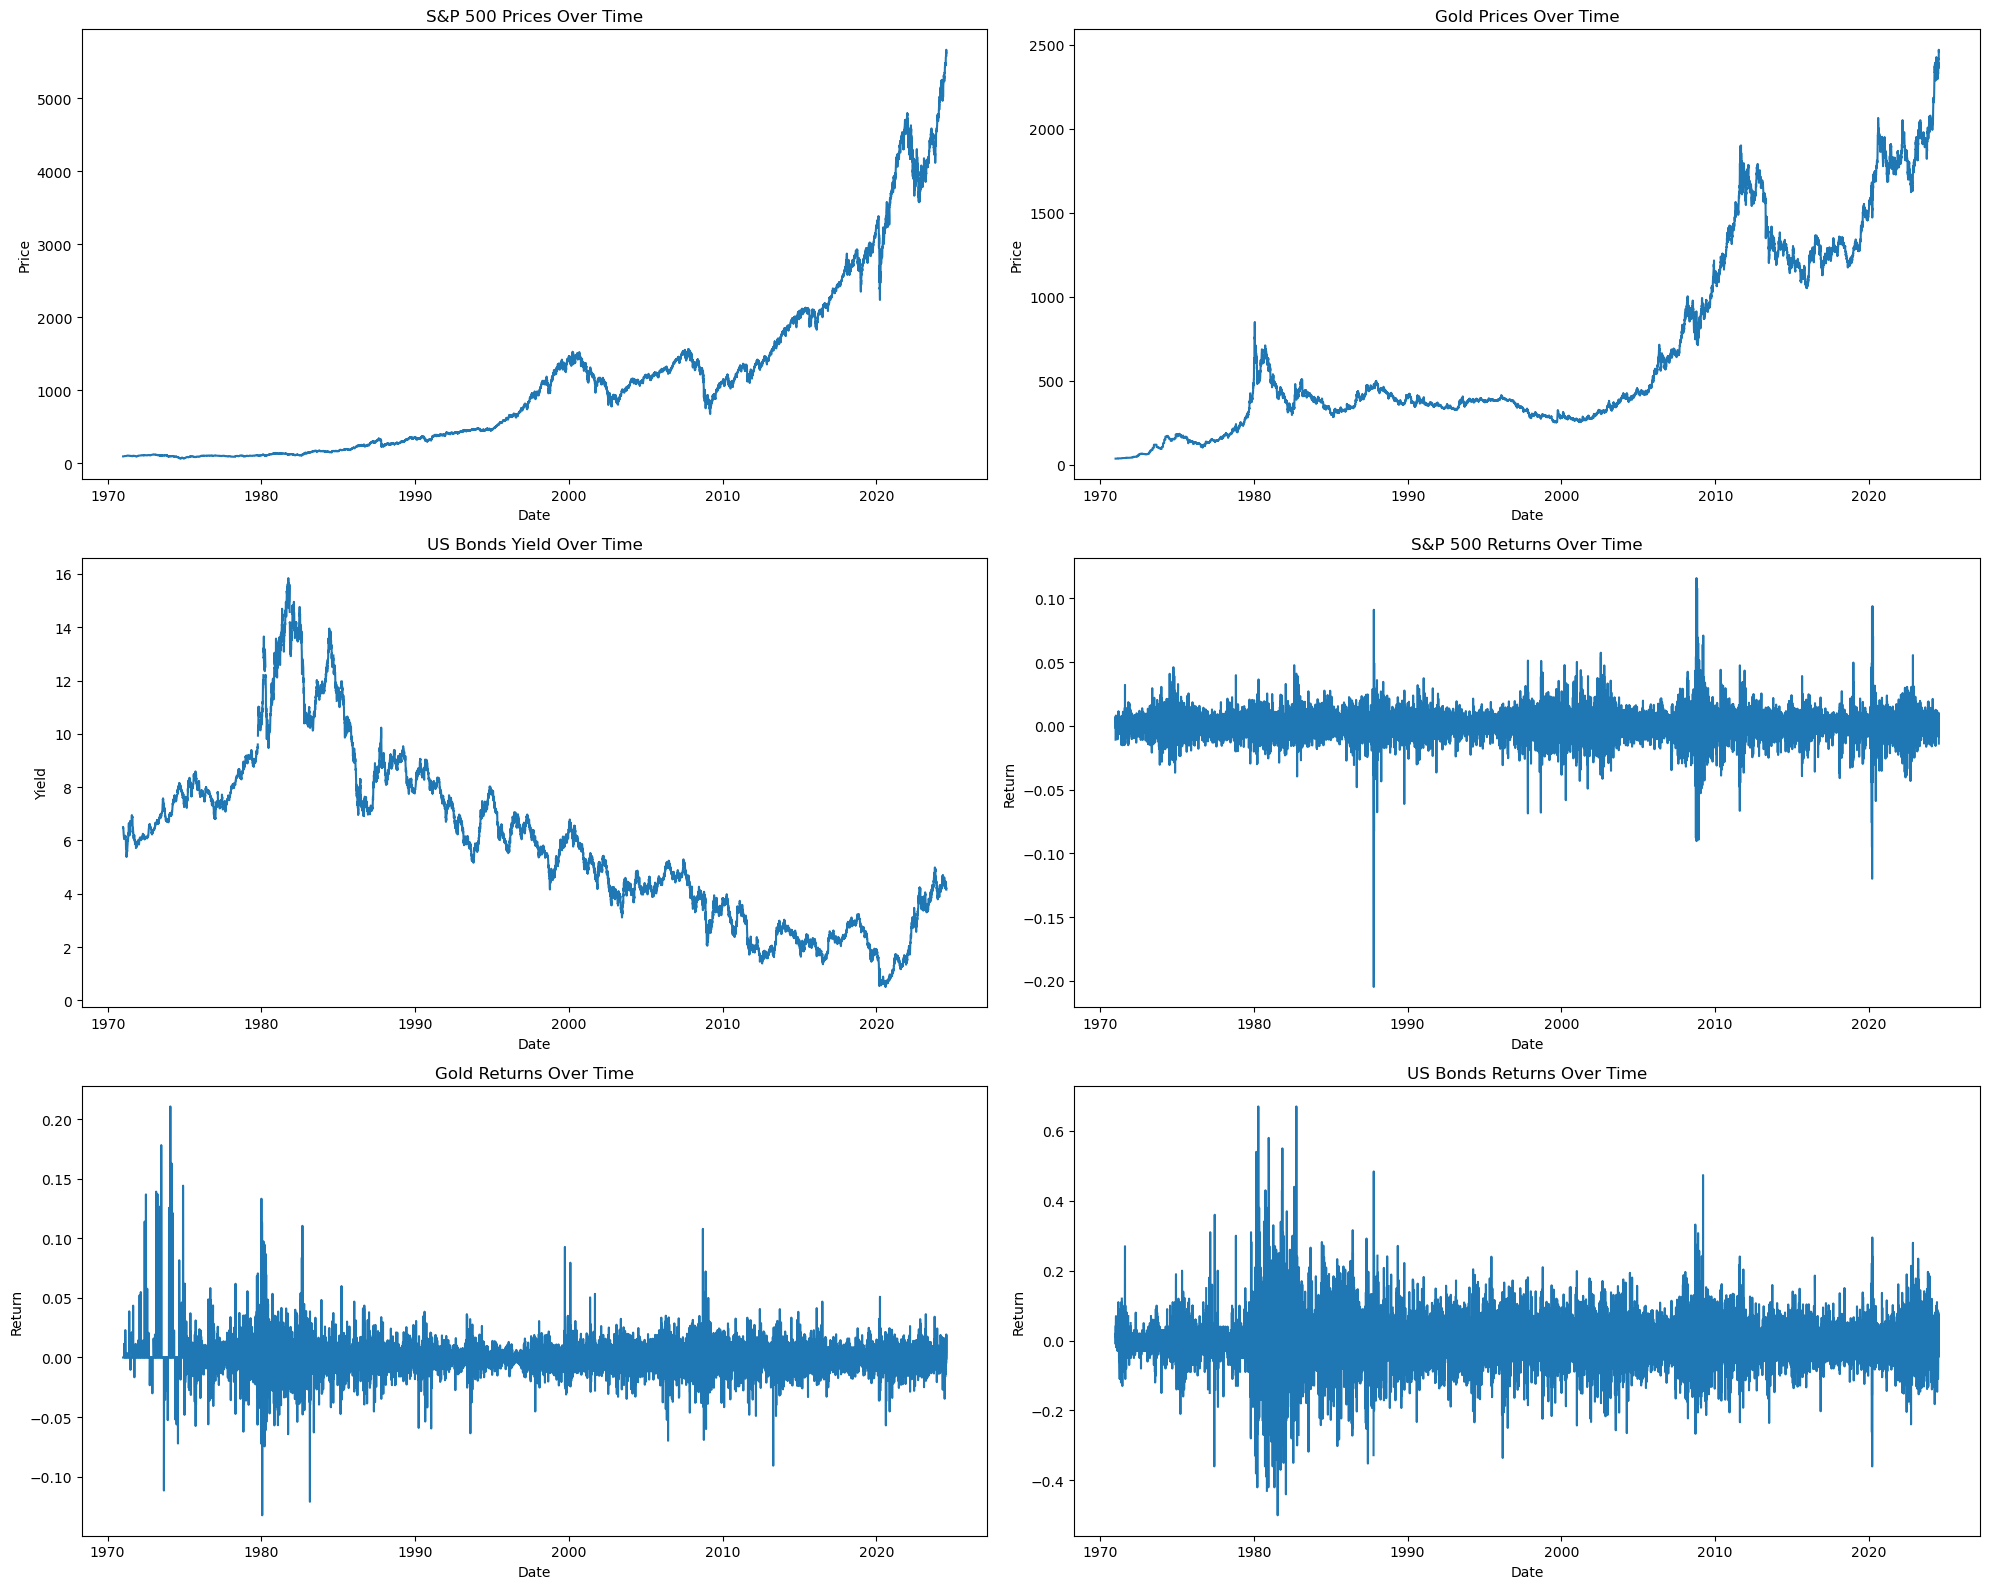

In [7]:
# Visualize the market_data
fig, axs = plt.subplots(3, 2, figsize=(20, 16))

# S&P 500 Prices Over Time
axs[0, 0].plot(market_data.index, market_data['S&P 500'])
axs[0, 0].set_title('S&P 500 Prices Over Time')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')

# Gold Prices Over Time
axs[0, 1].plot(market_data.index, market_data['Gold'])
axs[0, 1].set_title('Gold Prices Over Time')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')

# US Bonds Yield Over Time
axs[1, 0].plot(market_data.index, market_data['US 10YR Bonds'])
axs[1, 0].set_title('US Bonds Yield Over Time')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Yield')

# S&P 500 Returns Over Time
axs[1, 1].plot(market_data.index, market_data['S&P_500_Return'])
axs[1, 1].set_title('S&P 500 Returns Over Time')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Return')

# Gold Returns Over Time
axs[2, 0].plot(market_data.index, market_data['Gold_Return'])
axs[2, 0].set_title('Gold Returns Over Time')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Return')

# US Bonds Returns Over Time
axs[2, 1].plot(market_data.index, market_data['Bond_Return'])
axs[2, 1].set_title('US Bonds Returns Over Time')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Return')

# Display the plot
plt.tight_layout()
plt.show()


#### S&P 500 Prices:


- Shows a clear long-term upward trend from 1970 to 2020.
- Exhibits exponential growth, especially after 2010.
- Notable dips occur around 2000 (dot-com bubble) and 2008 (financial crisis).


#### Gold Prices:


- Overall upward trend, but with more volatility than S&P 500.
- Sharp spike in the early 1980s, followed by a long period of relatively stable prices.
- Significant increase starting around 2005.


#### US Bond Yields:


- Peaked in the early 1980s at around 16%.
- Overall downward trend since then, reaching historic lows by 2020.
- Suggests a long-term bull market for bonds as yields declined.


#### Returns:
- S&P 500 returns show consistent volatility over time, with some extreme outliers.
- Gold returns appear more volatile in the earlier years of the dataset.
- US Bond returns show increased volatility in the 1980s, corresponding to the yield spike.

# 3. Define Economic Regimes

In [8]:
def define_regimes(data, window=12):
    data['CPI_Rolling_Mean'] = data['CPI YOY'].rolling(window=window).mean()
    data['GDP_Rolling_Mean'] = data['GDP YOY'].rolling(window=window).mean()
    data['Regime'] = np.where((data['CPI YOY'] >= data['CPI_Rolling_Mean']) & (data['GDP YOY'] >= data['GDP_Rolling_Mean']), 'HGHI',
                     np.where((data['CPI YOY'] >= data['CPI_Rolling_Mean']) & (data['GDP YOY'] < data['GDP_Rolling_Mean']), 'LGHI',
                     np.where((data['CPI YOY'] < data['CPI_Rolling_Mean']) & (data['GDP YOY'] >= data['GDP_Rolling_Mean']), 'HGLI',
                     'LGLI')))
    return data
    
    return macro_df
macro_df = define_regimes(macro_df)

In [9]:
macro_df

,GDP YOY,CPI YOY,CPI_Rolling_Mean,GDP_Rolling_Mean,Regime
Date,,,,,
1970-12-31,-0.2,5.6,NaN,NaN,LGLI
1971-01-31,-0.2,5.3,NaN,NaN,LGLI
1971-02-28,-0.2,5.0,NaN,NaN,LGLI
1971-03-31,2.7,4.7,NaN,NaN,LGLI
1971-04-30,2.7,4.2,NaN,NaN,LGLI
...,...,...,...,...,...
2024-02-29,3.1,3.2,3.625000,2.525000,HGLI
2024-03-31,2.9,3.5,3.500000,2.625000,HGHI
2024-04-30,2.9,3.4,3.375000,2.725000,HGHI


# 4. Apply Regimes to Market Data

In [10]:
def apply_regimes(macro_df, market_data):
    date_range = pd.date_range(start=market_data.index.min(), end=market_data.index.max(), freq='D')
    all_dates = pd.DataFrame(index=date_range)
    
    regimes = all_dates.merge(macro_df[['Regime']], how='left', 
                              left_index=True, 
                              right_index=True)
    
    regimes['Regime'] = regimes['Regime'].ffill()
    
    market_data_with_regimes = market_data.merge(regimes, left_index=True, right_index=True, how='left')
    
    return market_data_with_regimes
market_data_with_regimes = apply_regimes(macro_df, market_data)

In [11]:
market_data_with_regimes

,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds,S&P_500_Return,Gold_Return,Bond_Return,Regime
Date,,,,,,,,
1970-12-31,92.15,37.44,120.643,6.5020,NaN,NaN,NaN,LGLI
1971-01-04,91.15,37.44,120.530,6.4620,-0.010852,0.000000,0.0400,LGLI
1971-01-05,91.80,37.44,120.520,6.4720,0.007131,0.000000,-0.0100,LGLI
1971-01-06,92.35,37.44,120.490,6.4720,0.005991,0.000000,-0.0000,LGLI
1971-01-07,92.38,37.44,120.550,6.4520,0.000325,0.000000,0.0200,LGLI
...,...,...,...,...,...,...,...,...
2024-07-11,5584.54,2415.48,104.440,4.2101,-0.008763,0.018648,0.0740,HGLI
2024-07-12,5615.35,2411.43,104.093,4.1829,0.005517,-0.001677,0.0272,HGLI
2024-07-15,5631.22,2422.27,104.189,4.2294,0.002826,0.004495,-0.0465,HGLI


In [12]:
market_data_with_regimes.index = pd.to_datetime(market_data_with_regimes.index)

# Create a mask for the dates you want in your training set
train_mask = (market_data_with_regimes.index.year >= 1970) & (market_data_with_regimes.index.year < 2022)

# Create the training and test sets
train = market_data_with_regimes.loc[train_mask]
test = market_data_with_regimes.loc[~train_mask]

In this code, train will contain the data from 1970 to 2021, and test will contain the data from 2022 onwards.

# 5. Portfolio Optimization Functions

- We use the Sharpe ratio as our optimization criterion, which balances return and risk.
- The optimization aims to find the mix of gold and bonds that provides the best risk-adjusted return.
- We assume a risk-free rate of 2% (adjustable parameter).
- The functions are designed to work with daily return data but produce annualized metrics.

These functions form the core of our portfolio optimization process, allowing us to find the optimal hedge composition for each economic regime based on historical performance.

In [13]:
def objective_function(weights, returns, target_diversity=0.3):
    sharpe = -neg_sharpe_ratio(weights, returns, risk_free_rate)
    diversity_penalty = abs(weights[0] - 0.5) + abs(weights[1] - 0.5)
    return sharpe - target_diversity * diversity_penalty

def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov().values
    assets_stdev = np.sqrt(np.diag(cov_matrix))
    weights = 1 / assets_stdev
    return weights / np.sum(weights)

def portfolio_return(weights, returns):
    return np.sum(returns.mean() * weights) * 12  # Annualized

def portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))

def sharpe_ratio(weights, returns, risk_free_rate):
    """
    Calculate the Sharpe ratio for a given portfolio
    """
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility


def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov().values
    assets_stdev = np.sqrt(np.diag(cov_matrix))
    weights = 1 / assets_stdev
    return weights / np.sum(weights)

def conditional_optimize_portfolio(returns, regime, risk_free_rate=0.02):
    """
    Optimize portfolio based on the specific economic regime
    """
    if regime in ['HGLS', 'HGLW']:  # High Growth, Low Inflation
        return hgli_strategy(returns, risk_free_rate)
    elif regime in ['HGHS', 'HGHW']:  # High Growth, High Inflation
        return hghi_strategy(returns, risk_free_rate)
    elif regime in ['LGLS', 'LGLW']:  # Low Growth, Low Inflation
        return lgli_strategy(returns, risk_free_rate)
    else:  # Low Growth, High Inflation
        return lghi_strategy(returns, risk_free_rate)
    
stop_loss_level = -0.2 
def apply_stop_loss(portfolio_returns, stop_loss_level):
    """
    This function applies a stop-loss rule to a portfolio.
    If the portfolio value drops by more than the stop-loss level,
    it moves all assets to a safer asset (e.g., Bonds).
    """
    # Calculate the portfolio value
    portfolio_value = (1 + portfolio_returns).cumprod()
    
    # Check if the portfolio value has dropped by more than the stop-loss level
    if (portfolio_value.pct_change() < stop_loss_level).any():
        return [0.0, 1.0]  # Move all to Bonds
    else:
        return None

rebalance_freq = 'Q'
def rebalance_portfolio(returns, risk_free_rate, bounds, rebalance_freq):
    """
    This function rebalances the portfolio at the specified frequency
    by recalculating the optimal weights.
    """
    # Define your rebalancing frequency
    rebalance_dates = pd.date_range(returns.index[0], returns.index[-1], freq=rebalance_freq)
    
    # Initialize weights
    weights = [0.5, 0.5]
    
    # Loop through each period and adjust the weights
    for date in rebalance_dates:
        period_returns = returns.loc[:date]
        weights = optimize_strategy(period_returns, risk_free_rate, bounds)  # Recalculate weights
    
    return weights

# 5. Analyze Regimes and Optimize Hedges

In [14]:
def optimize_strategy(returns, risk_free_rate, bounds, stop_loss_level = None, rebalance_freq = None, additional_objective=None):
    def objective(weights):
        base_obj = -sharpe_ratio(weights, returns, risk_free_rate)
        return base_obj + (additional_objective(weights) if additional_objective else 0)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(objective, [0.5, 0.5], method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Apply stop-loss rule
    if stop_loss_level is not None:
        stop_loss_weights = apply_stop_loss((returns * result.x).sum(axis=1), stop_loss_level)
        if stop_loss_weights is not None:
            result.x = stop_loss_weights
    
    # Apply rebalancing
    if rebalance_freq is not None:
        result.x = rebalance_portfolio(returns, risk_free_rate, bounds, rebalance_freq)
    
    return result.x



def analyze_regimes(market_data_with_regimes):
    regimes = ['HGLI', 'HGHI', 'LGLI', 'LGHI']
    results = {regime: {} for regime in regimes}

    for regime in regimes:
        regime_data = market_data_with_regimes[market_data_with_regimes['Regime'] == regime]
        returns = regime_data[['Gold_Return', 'Bond_Return']]
        
        if regime == 'HGLI':
            bounds = ((0.1, 0.6), (0.4, 0.9))
            # Introduce a volatility constraint for HGLI regime
            additional_obj = lambda w: 0.5 * np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w)))
        elif regime == 'HGHI':
            bounds = ((0.3, 0.9), (0.1, 0.7))
            additional_obj = lambda w: -0.5 * w[0]  # Favor gold for inflation protection
        elif regime == 'LGLI':
            bounds = ((0.1, 0.6), (0.4, 0.9))
            # Introduce a volatility constraint for LGLI regime
            additional_obj = lambda w: 0.5 * np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w)))
        else:  # LGHI
            bounds = ((0.3, 0.9), (0.1, 0.7))
            additional_obj = lambda w: -0.5 * w[0]  # Favor gold for inflation protection
        
        risk_free_rate = 0.02 if 'L' in regime else 0.03  # Higher rate for high growth regimes
        
        results[regime]['optimal_weights'] = optimize_strategy(returns, risk_free_rate, bounds, stop_loss_level, rebalance_freq,
                                                               additional_obj if 'additional_obj' in locals() else None)
        results[regime]['risk_parity_weights'] = 1 / np.sqrt(np.diag(returns.cov()))
        results[regime]['risk_parity_weights'] /= sum(results[regime]['risk_parity_weights'])
        
        results[regime]['sharpe_ratio'] = sharpe_ratio(results[regime]['optimal_weights'], returns, risk_free_rate)
        results[regime]['annualized_return'] = np.sum(returns.mean() * results[regime]['optimal_weights']) * 252
        results[regime]['annualized_volatility'] = np.sqrt(np.dot(results[regime]['optimal_weights'].T, 
                                                           np.dot(returns.cov() * 252, results[regime]['optimal_weights'])))
        results[regime]['correlations'] = regime_data[['S&P_500_Return', 'Gold_Return', 'Bond_Return']].corr()['S&P_500_Return'][1:]

    # Print results
    for regime, data in results.items():
        print(f"\nRegime: {regime}")
        print(f"Sharpe Ratio: {data['sharpe_ratio']:.4f}")
        print(f"Optimal Weights: Gold = {data['optimal_weights'][0]:.2f}, Bonds = {data['optimal_weights'][1]:.2f}")
        print(f"Risk Parity Weights: Gold = {data['risk_parity_weights'][0]:.2f}, Bonds = {data['risk_parity_weights'][1]:.2f}")
        print(f"Annualized Return: {data['annualized_return']*100:.2f}%")
        print(f"Annualized Volatility: {data['annualized_volatility']*100:.2f}%")

    # Print correlations and regime distribution
    print("\nCorrelations with S&P 500:")
    for regime, data in results.items():
        print(f"\n{regime}:")
        print(data['correlations'])

    regime_counts = market_data_with_regimes['Regime'].value_counts()
    total_days = len(market_data_with_regimes)
    print("\nRegime Distribution:")
    for regime, count in regime_counts.items():
        print(f"{regime}: {count} days ({count/total_days*100:.2f}%)")

    return results


# 6. Main Execution and Results Display

### a. In-sample data

In [15]:
result = analyze_regimes(train)
# Call the function with your results

/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Regime: HGLI
Sharpe Ratio: -0.0229
Optimal Weights: Gold = 0.10, Bonds = 0.90
Risk Parity Weights: Gold = 0.87, Bonds = 0.13
Annualized Return: -0.34%
Annualized Volatility: 102.06%

Regime: HGHI
Sharpe Ratio: 0.4624
Optimal Weights: Gold = 0.90, Bonds = 0.10
Risk Parity Weights: Gold = 0.85, Bonds = 0.15
Annualized Return: 11.46%
Annualized Volatility: 18.29%

Regime: LGLI
Sharpe Ratio: 0.1546
Optimal Weights: Gold = 0.60, Bonds = 0.40
Risk Parity Weights: Gold = 0.87, Bonds = 0.13
Annualized Return: 9.74%
Annualized Volatility: 50.06%

Regime: LGHI
Sharpe Ratio: 0.5802
Optimal Weights: Gold = 0.90, Bonds = 0.10
Risk Parity Weights: Gold = 0.81, Bonds = 0.19
Annualized Return: 16.56%
Annualized Volatility: 25.09%

Correlations with S&P 500:

HGLI:
Gold_Return   -0.008643
Bond_Return    0.021327
Name: S&P_500_Return, dtype: float64

HGHI:
Gold_Return   -0.060564
Bond_Return   -0.149111
Name: S&P_500_Return, dtype: float64

LGLI:
Gold_Return    0.098517
Bond_Return    0.022307
Name: S&

## Comments on In-Sample Results:

The provided data suggests some interesting insights about hedging the S&P 500 with gold and bonds based on different economic regimes (HGLI - High Growth, Low Inflation; HGHI - High Growth, High Inflation; LGLI - Low Growth, Low Inflation; LGHI - Low Growth, High Inflation). Here's a breakdown:

**Regime Performance:**

* **High Growth Regimes (HGHI & LGHI):** Both regimes show positive annualized returns for the S&P 500 (11.46% & 16.56%) with lower volatility compared to Low Growth Regimes.
* **Low Growth Regimes (HGLI & LGLI):**  These regimes display negative or low positive returns with higher volatility. LGLI has a slightly better Sharpe Ratio (0.1546) compared to HGLI (-0.0229), indicating a potential benefit from the hedge during low growth periods.

**Hedge Effectiveness:**

* **Optimal Weights vs. Risk Parity Weights:** The optimal weights prioritize maximizing returns based on the regime, while risk parity weights aim for equal risk contribution from each asset. 
* **High Inflation Regimes (HGHI):** Here, both optimal and risk parity weights have a higher allocation to gold (around 85-90%). This might be due to gold's potential to act as an inflation hedge. The HGHI regime also shows a negative correlation between gold and S&P 500 returns, potentially offering some protection during high inflation periods.
* **Low Inflation Regimes (HGLI & LGLI):**  The optimal weights allocate more to bonds (up to 90%) in these regimes, suggesting a potential benefit from bonds' stability during low inflation. However, the correlations between gold and S&P 500 returns are weak or even slightly positive, limiting gold's effectiveness as a hedge.

**Limitations:**

* **In-sample data:** The analysis is based on historical data, and past performance doesn't guarantee future results. Economic regimes can change, and hedge effectiveness might vary.
* **Transaction costs:** The data doesn't consider transaction costs associated with buying and selling gold and bonds. These costs can erode returns.

## Overall

These in-sample results suggest that a combination of gold and bonds might offer some hedging benefits for the S&P 500 depending on the economic regime. High inflation regimes seem to favor a higher gold allocation, while low inflation regimes might benefit more from bonds. However, it's important to remember the limitations and consider factors like transaction costs before implementing such a strategy.


### b. Out-of-sample data

In [16]:
result1 = analyze_regimes(test)


Regime: HGLI
Sharpe Ratio: -0.1525
Optimal Weights: Gold = 0.60, Bonds = 0.40
Risk Parity Weights: Gold = 0.89, Bonds = 0.11
Annualized Return: -4.94%
Annualized Volatility: 45.55%

Regime: HGHI
Sharpe Ratio: -0.1072
Optimal Weights: Gold = 0.90, Bonds = 0.10
Risk Parity Weights: Gold = 0.85, Bonds = 0.15
Annualized Return: 1.20%
Annualized Volatility: 16.82%

Regime: LGLI
Sharpe Ratio: 1.1834
Optimal Weights: Gold = 0.60, Bonds = 0.40
Risk Parity Weights: Gold = 0.89, Bonds = 0.11
Annualized Return: 68.70%
Annualized Volatility: 56.36%

Regime: LGHI
Sharpe Ratio: -2.3358
Optimal Weights: Gold = 0.30, Bonds = 0.70
Risk Parity Weights: Gold = 0.90, Bonds = 0.10
Annualized Return: -212.35%
Annualized Volatility: 91.77%

Correlations with S&P 500:

HGLI:
Gold_Return    0.075340
Bond_Return    0.183917
Name: S&P_500_Return, dtype: float64

HGHI:
Gold_Return    0.023157
Bond_Return    0.119225
Name: S&P_500_Return, dtype: float64

LGLI:
Gold_Return    0.217672
Bond_Return    0.136722
Name:

/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/linhtrankhanh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


## Analysis of Out-of-Sample Results:

The provided out-of-sample data offers valuable insights into the real-world effectiveness of the hedging strategy compared to the in-sample analysis. Here's a breakdown of the key observations:

**Performance Discrepancy:**

* **Sharpe Ratios:**  Most regimes show significantly lower Sharpe Ratios compared to the in-sample data, suggesting a potential decline in risk-adjusted returns. 
* **Returns:** 
    * **LGLI:** This regime stands out with a very high return (68.70%) during the out-of-sample period. This could be due to a specific economic situation that favored the chosen hedge combination.
    * **LGHI:** Conversely, the LGHI regime experienced a significant negative return (-212.35%), highlighting the potential downside risk of the strategy.

**Hedge Effectiveness:**

* **Correlations:** Interestingly, some correlations between gold and S&P 500 returns became positive in the out-of-sample period (HGLI, LGLI). This could explain why the hedge wasn't as effective in these regimes.
* **Weighting Strategies:** Both optimal and risk parity weights seem to have underperformed compared to in-sample results across most regimes. 

**Regime Distribution:**

* The distribution of regimes changed in the out-of-sample period. There's a higher prevalence of HGLI (41.33%) compared to HGHI (12.67%), suggesting a potential shift in the economic landscape.

**Limitations:**

* **Limited Out-of-Sample Data:** The provided data only covers a short period (from 2022 to 2024).  A longer timeframe would provide a more robust picture of the strategy's effectiveness.

## Overall

The out-of-sample results highlight the challenges of relying solely on historical data for hedge strategy development. While the in-sample analysis suggested some promise, the out-of-sample results show a significant performance difference. This emphasizes the importance of:

* **Constant Monitoring:**  Economic regimes can change dynamically. Regularly monitoring economic indicators and adjusting the hedge strategy accordingly is crucial.
* **Stress Testing:**  Testing the strategy against various economic scenarios (including extreme events) can help identify potential weaknesses.
* **Diversification:**  Consider including additional assets beyond gold and bonds to potentially improve risk-adjusted returns. 